In [30]:
import os
import json
from collections import defaultdict
from datetime import datetime
import re

# Step 1: Read the JSON files from "Raw Data" folder
raw_data_folder = "Raw Data"
cve_dates = {}

# Regular expression to match valid CVE IDs (e.g., CVE-2022-42518)
cve_pattern = re.compile(r"CVE-\d{4}-\d{4,7}")

# Loop through all JSON files in the "Raw Data" folder
for filename in os.listdir(raw_data_folder):
    if filename.endswith(".json"):
        filepath = os.path.join(raw_data_folder, filename)
        with open(filepath, "r") as file:
            data = json.load(file)
            for entry in data:
                cve_id = entry.get("CVE ID")
                published_date = entry.get("Published Date")
                if cve_id and published_date:
                    cve_dates[cve_id.strip()] = published_date.strip()

# Step 2: Read the base.json file
base_results_file = os.path.join("Llama-2", "Llama-2-Set-1.json")
with open(base_results_file, "r") as file:
    base_results = json.load(file)

# Step 3: Categorize the results by month and year
results_by_date = defaultdict(lambda: {"correct": 0, "incorrect": 0})
missing_dates = []

def normalize_cve_id(cve_text):
    """Extract and normalize the CVE ID from a given text."""
    match = cve_pattern.search(cve_text)
    if match:
        return match.group(0)
    return None

for result in base_results:
    question = result.get("Question", "")
    cve_id = normalize_cve_id(question)

    if cve_id:
        if cve_id in cve_dates:
            published_date = cve_dates[cve_id]
            # Convert the date to month/year format
            try:
                date_obj = datetime.strptime(published_date, "%d/%m/%Y")
                date_key = date_obj.strftime("%Y-%m")
            except ValueError:
                # If date parsing fails, skip this entry
                continue

            validation = int(result.get("GPT-3.5 Validation", 0))
            if validation == 1:
                results_by_date[date_key]["correct"] += 1
            else:
                results_by_date[date_key]["incorrect"] += 1
        else:
            missing_dates.append(cve_id)

# Step 4: Print the results
print("Results categorized by month/year:")
for date_key, counts in results_by_date.items():
    print(f"{date_key}: Correct - {counts['correct']}, Incorrect - {counts['incorrect']}")

if missing_dates:
    print("\nCVE IDs with missing dates:")
    for cve_id in missing_dates:
        print(cve_id)


Results categorized by month/year:
2023-06: Correct - 332, Incorrect - 91
2023-05: Correct - 178, Incorrect - 76
2023-08: Correct - 131, Incorrect - 60
2023-10: Correct - 352, Incorrect - 118
2023-04: Correct - 210, Incorrect - 66
2023-07: Correct - 156, Incorrect - 44
2023-09: Correct - 109, Incorrect - 57
2023-11: Correct - 406, Incorrect - 158
2022-12: Correct - 112, Incorrect - 40
2023-02: Correct - 71, Incorrect - 25
2023-03: Correct - 228, Incorrect - 59
2023-01: Correct - 106, Incorrect - 42
2023-12: Correct - 210, Incorrect - 89
2022-11: Correct - 26, Incorrect - 7
2022-10: Correct - 3, Incorrect - 3


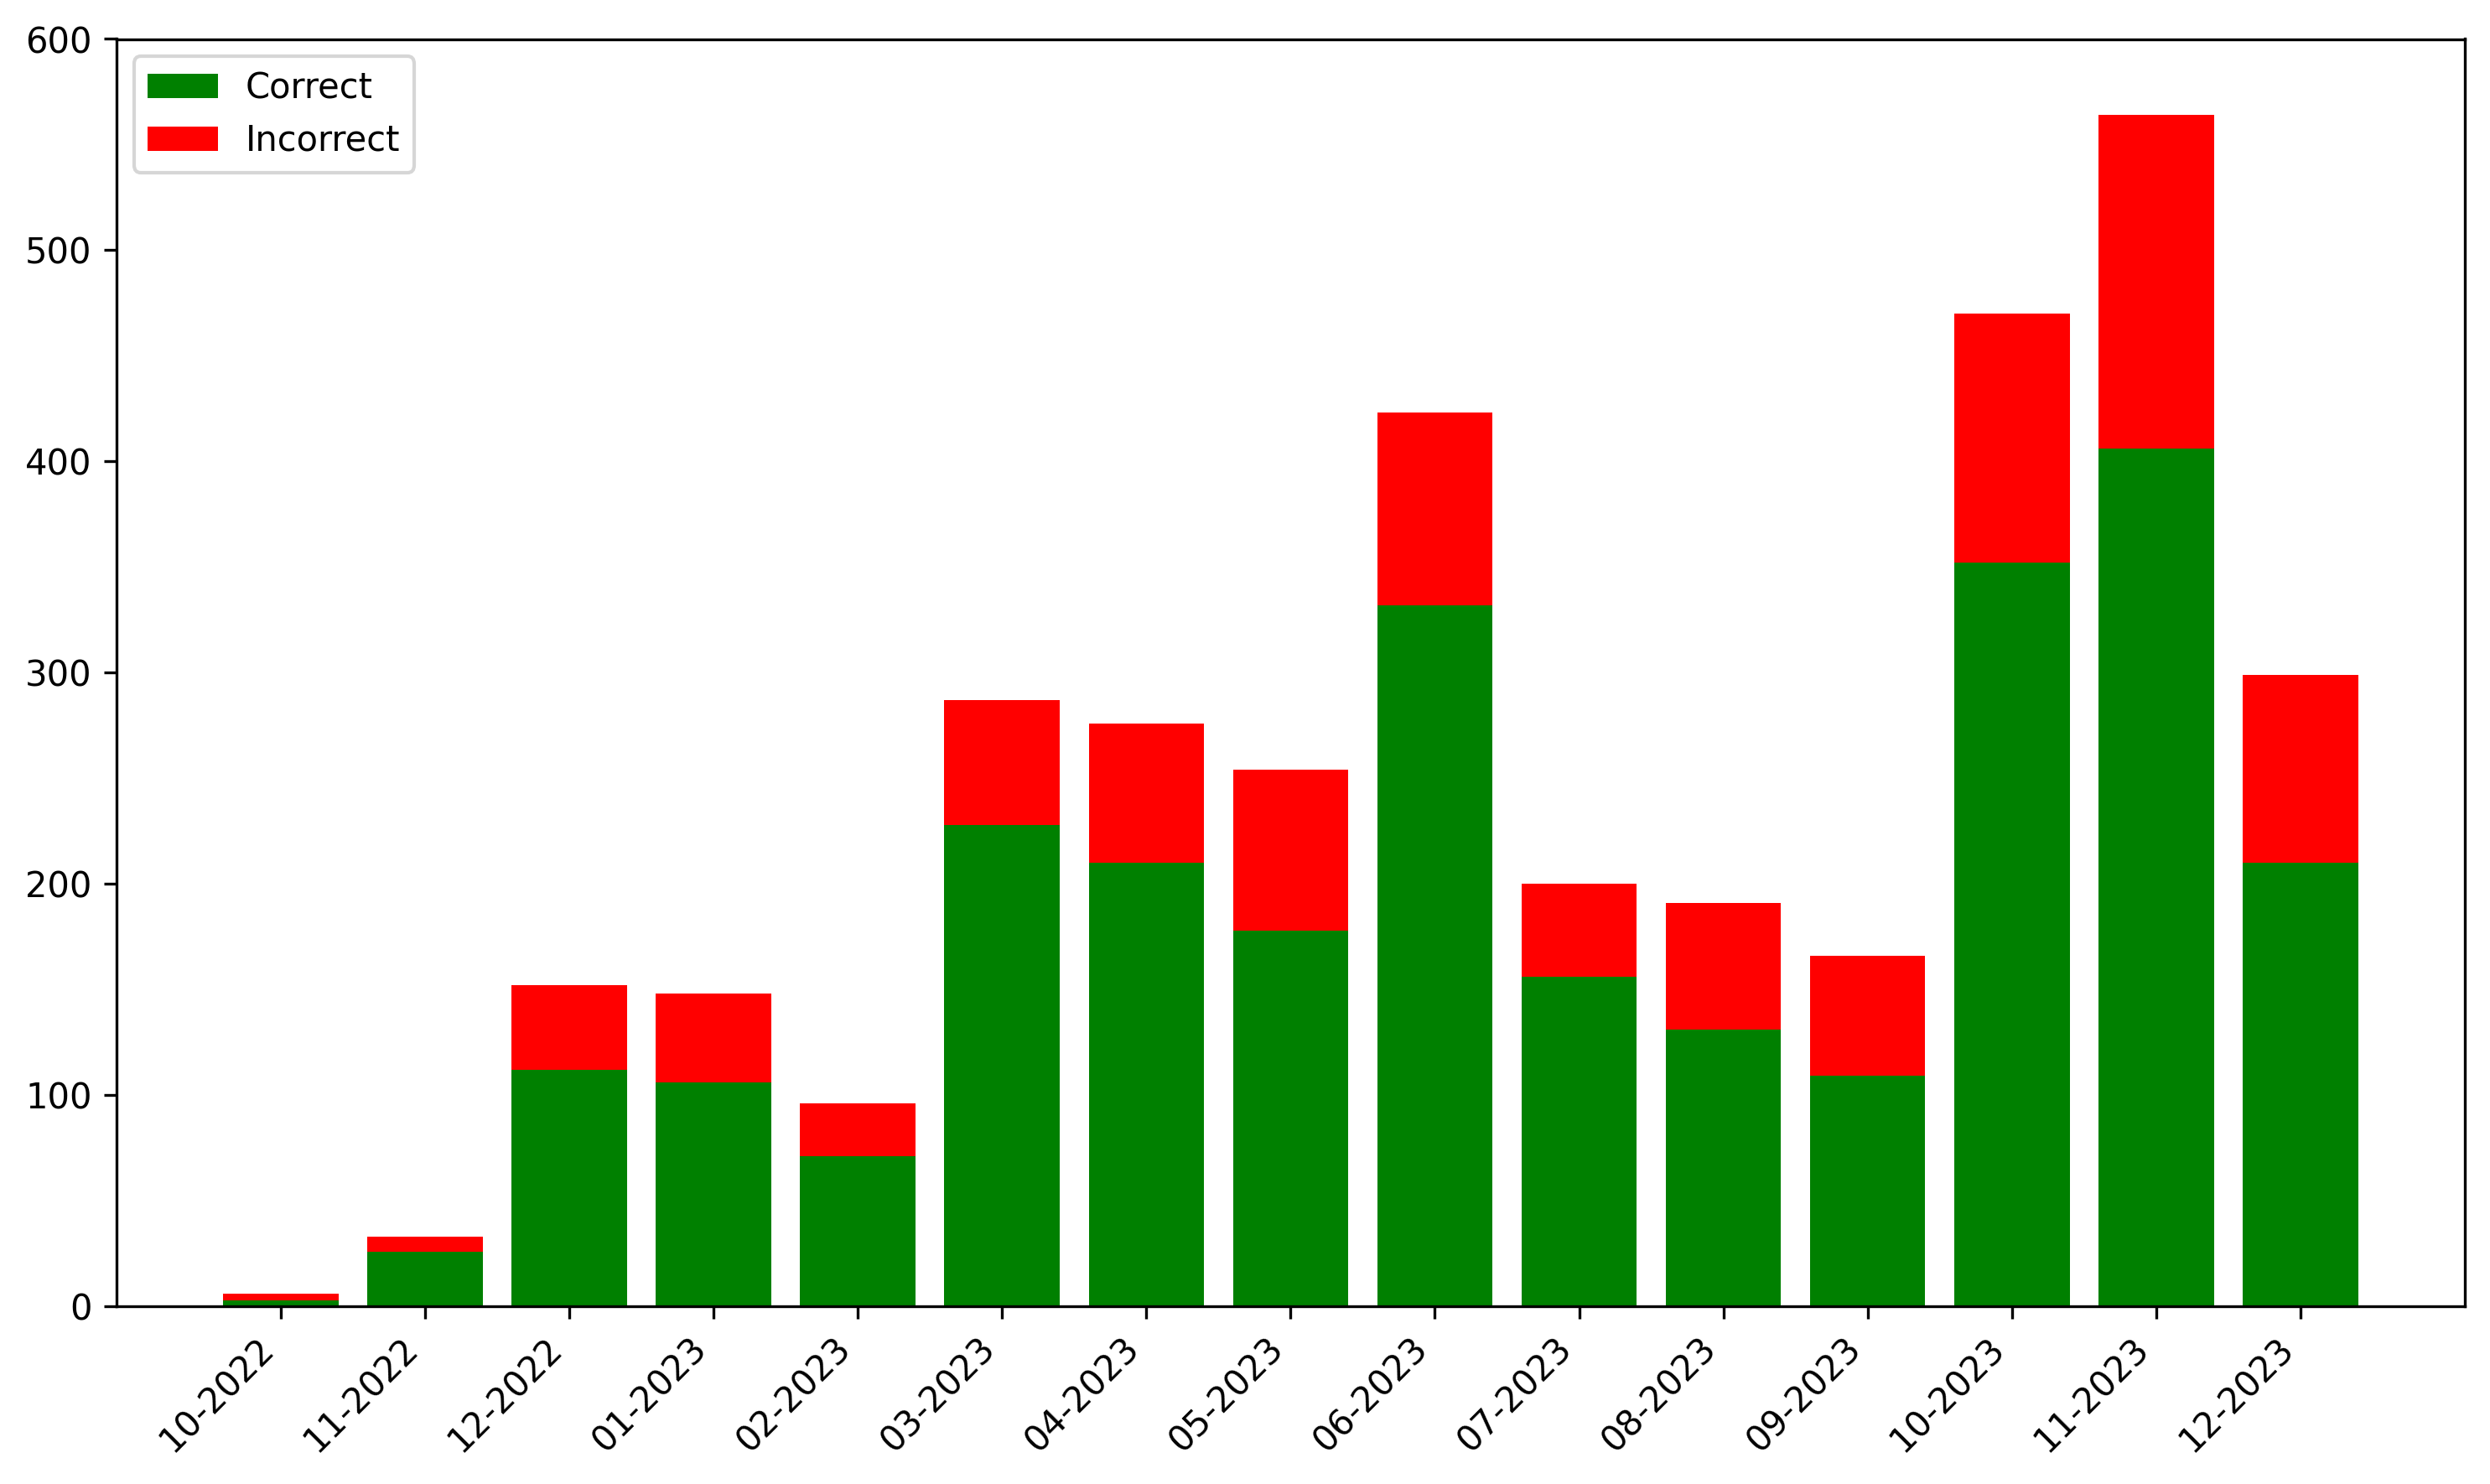

In [31]:
import matplotlib.pyplot as plt

# Convert the results_by_date dictionary into separate lists for plotting
months = []
correct_counts = []
incorrect_counts = []

for date_key, counts in sorted(results_by_date.items()):
    # Convert date_key from "YYYY-MM" to "MM-YYYY"
    month_year = datetime.strptime(date_key, "%Y-%m").strftime("%m-%Y")
    months.append(month_year)
    correct_counts.append(counts["correct"])
    incorrect_counts.append(counts["incorrect"])

# Plotting the stacked bar graph
plt.figure(figsize=(10, 6), dpi=300)

plt.bar(months, correct_counts, label='Correct', color='green')
plt.bar(months, incorrect_counts, bottom=correct_counts, label='Incorrect', color='red')

# plt.xlabel('Month-Year')
# plt.ylabel('Number of Answers')
# plt.title('Correct vs Incorrect Answers by Month/Year')
plt.xticks(rotation=45, ha='right')
plt.yticks(range(0, 700, 100))
plt.legend()

plt.tight_layout()
plt.show()
